In [1]:
import pandas as pd
import numpy as np
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import DistanceMetric
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import statistics
import pyclustering
from pyclustering.cluster.kmedoids import kmedoids
import gower
import seaborn as sns
import pyclustering
from sklearn.metrics.pairwise import pairwise_distances
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmedoids import kmedoids

# Read dataset

In [2]:
df = pd.read_excel("german_credit_data.xlsx")
df['label'] = (df.Risk == 'good').astype(int)
df.drop(['Unnamed: 0','Risk'],axis=1,inplace=True)
df = df.replace(np.nan, 'unknown', regex=True)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,label
0,67,male,2,own,unknown,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,unknown,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


Below we define which features are categorical and which are numerical. 

In [3]:
#Create lists of categorical and numerical features
num_features = ['Age','Credit amount','Duration']
cat_features = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']
all_features = ['Age','Credit amount','Duration','Sex','Job','Housing','Saving accounts','Checking account','Purpose']

# k-medoids clustering

In [4]:
#This function compute the Gower distance matrix
# input: NxM feature matrix
# output: NxN distance matrix 

def gower_distance(matrix):
    output = gower.gower_matrix(matrix)
    return output

Below we define the feature matrix (X) and the lavel vector (y). We also choose the number of clusters k and initialize the first cluster. 

In [5]:
X = df.loc[: , df.columns != 'label']
y = df.loc[: , df.columns == 'label']
k = 2 #number of clusters each clustering step
l = 6 #number of layers; NOTE: first layer ("layer 0") is the whole dataset so always fill in #layers+1
n = len(X)

t0=time.time()

dict_layers = {0:[X.index.tolist()]}
dict_medoids = {0:[]}
for i in np.arange(1,l):
    dict_layers[i] = []
    dict_medoids[i] = []


for layer in np.arange(l-1): #iterate over layers
    
    for i in np.arange(k**layer): #iterate over clusters in layer 
        X_subset = X.loc[dict_layers[layer][i],:]
        
        index_book = {} #keep track of indices of cluster i
        teller = 0 
        for index in X_subset.index:
            index_book[teller] = index
            teller += 1
        
        X_subset = X_subset.reset_index(drop=True) #reset index of cluster i before cluster analysis
        
        initial_medoids = np.sort(random.sample(list(X_subset.index),k))
        kmedoids_instance = kmedoids(gower_distance(X_subset),initial_medoids,data_type='distance_matrix',iter_max=1000)
        kmedoids_instance.process()
        clusters = kmedoids_instance.get_clusters()
        centers = kmedoids_instance.get_medoids()
    
        for j in np.arange(k): #translate cluster index back to original
            translated_cluster = []
            for item in clusters[j]:
                translated_cluster.append(index_book[item])
            dict_medoids[layer+1].append(index_book[centers[j]])
            dict_layers[layer+1].append(translated_cluster)

final_clusters = dict_layers[l-1]
final_medoids = dict_medoids[l-1]

#sort the clusters, in this way we always obtain the same cluster numbers 
sort_clusters = final_clusters.copy()
sort_clusters.sort(key=len)
sort_centers = []
for i in np.arange(k**(l-1)):
    for j in np.arange(k**(l-1)):
        if (sort_clusters[i] == final_clusters[j]):
            sort_centers.append(final_medoids[j])
            
print("training time:", round(time.time()-t0, 3), "s")
print("Final number of clusters:", len(sort_clusters))

training time: 1.638 s
Final number of clusters: 32


In [6]:
for i in np.arange(k**(l-1)):
    print('---------------------------------------------------------------------------')
    print('cluster ', i, '\t', sort_clusters[i] , '\n', 'medoid ', sort_centers[i])

---------------------------------------------------------------------------
cluster  0 	 [197, 721] 
 medoid  197
---------------------------------------------------------------------------
cluster  1 	 [63, 145, 887] 
 medoid  887
---------------------------------------------------------------------------
cluster  2 	 [82, 391, 752] 
 medoid  752
---------------------------------------------------------------------------
cluster  3 	 [194, 342, 470, 677] 
 medoid  194
---------------------------------------------------------------------------
cluster  4 	 [249, 386, 660, 675, 817] 
 medoid  249
---------------------------------------------------------------------------
cluster  5 	 [83, 429, 471, 573, 610, 640, 711, 722, 751] 
 medoid  751
---------------------------------------------------------------------------
cluster  6 	 [108, 118, 166, 312, 319, 396, 441, 750, 771, 802] 
 medoid  802
---------------------------------------------------------------------------
cluster  7 	 [168, 

# Train ML algorithm 

In [7]:
import xgboost as xgb
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

In [8]:
data = df.loc[: , df.columns != 'label']
label = df.loc[: , df.columns == 'label']

le = preprocessing.LabelEncoder()
for column in cat_features:
    le.fit(data[column])
    data[column] = le.fit_transform(data[column])

X_train, X_test, y_train, y_test = train_test_split(data, np.ravel(label), test_size=0.30, random_state=78) # 70% training and 30% test

<ipython-input-8-e9bf63b1c235>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = le.fit_transform(data[column])


### 1. Logistic Regression 

In [9]:
#train logistic regression model and check performance
clf = LogisticRegression(random_state=100,max_iter=500).fit(X_train, y_train)
clf_predictions_train = clf.predict(X_train)
clf_predictions_test = clf.predict(X_test)
clf_predictions_total = clf.predict(data)

p_correct_train = 1 - (abs(clf_predictions_train-y_train).sum() / len(y_train))
p_correct_test = 1 - (abs(clf_predictions_test-y_test).sum() / len(y_test))
p_correct_total = 1 - (abs(clf_predictions_total-np.ravel(label)).sum() / len(np.ravel(label)))

print('correct predictions train set' ,'\t', p_correct_train*100)
print('correct predictions test set' , '\t',  p_correct_test*100)
print('correct predictions total set' , '\t', p_correct_total*100)

correct predictions train set 	 74.28571428571429
correct predictions test set 	 73.66666666666667
correct predictions total set 	 74.1


### 2. XGboost classifier

In [10]:
#train XGboost
xg_clf = xgb.XGBClassifier(max_depth=5, gamma=1, use_label_encoder=False,eval_metric='error')
xg_clf.fit(X_train, y_train)

xg_predictions_train = xg_clf.predict(X_train)
xg_predictions_test = xg_clf.predict(X_test)
xg_predictions_total = xg_clf.predict(data)

p_correct_train = 1 - (abs(xg_predictions_train-y_train).sum() / len(y_train))
p_correct_test = 1 - (abs(xg_predictions_test-y_test).sum() / len(y_test))
p_correct_total = 1 - (abs(xg_predictions_total-np.ravel(label)).sum() / len(np.ravel(label)))

print('correct predictions train set' ,'\t', p_correct_train*100)
print('correct predictions test set' , '\t',  p_correct_test*100)
print('correct predictions total set' , '\t', p_correct_total*100)

correct predictions train set 	 91.0
correct predictions test set 	 74.0
correct predictions total set 	 85.9


### 3. Support Vector Machine classifier 

In [11]:
from sklearn import svm

svm_clf = svm.SVC()
svm_clf.fit(X_train,y_train)

svm_predictions_train = svm_clf.predict(X_train)
svm_predictions_test = svm_clf.predict(X_test)
svm_predictions_total = svm_clf.predict(data)

p_correct_train = 1 - (abs(svm_predictions_train-y_train).sum() / len(y_train))
p_correct_test = 1 - (abs(svm_predictions_test-y_test).sum() / len(y_test))
p_correct_total = 1 - (abs(svm_predictions_total-np.ravel(label)).sum() / len(np.ravel(label)))

print('correct predictions train set' ,'\t', p_correct_train*100)
print('correct predictions test set' , '\t',  p_correct_test*100)
print('correct predictions total set' , '\t', p_correct_total*100)

correct predictions train set 	 71.28571428571429
correct predictions test set 	 69.66666666666667
correct predictions total set 	 70.8


# 3.a Evaluation of Clustering method 

## Stability towards initialization 

We test the stability of the clustering method towards the initialization of the clusters by running the algorithm multiple times for different (random) initializations and compare the final clusters. 

In [9]:
l = 6
k = 2

test_stability = [] #list with unique cluster-combinations
all_clusters = [] #list with all clusters
test_medoids = [] #list with medoids of the unique cluster-combinations
t_s = 100 #number of runs
list_time = []

for test in np.arange(t_s):
    t0=time.time()

    dict_layers = {0:[X.index.tolist()]} #keep track of clusters by layer
    dict_medoids = {0:[]} #keep track of medoids by layer
    for i in np.arange(1,l): 
        dict_layers[i] = []
        dict_medoids[i] = []

    for layer in np.arange(l-1): #iterate over layers
        for i in np.arange(k**layer): #iterate over number of clusters within one layer
            X_subset = X.loc[dict_layers[layer][i],:] #subset of cluster
            
            #create an index_book to keep track of original indices
            index_book = {}
            teller = 0 
            for index in X_subset.index:
                index_book[teller] = index
                teller += 1
        
            X_subset = X_subset.reset_index(drop=True) #reset index before running clustering algorithm 
        
            #run clustering algorithm 
            initial_medoids = np.sort(random.sample(list(X_subset.index),k))
            kmedoids_instance = kmedoids(gower_distance(X_subset),initial_medoids,data_type='distance_matrix',iter_max=1000)
            kmedoids_instance.process()
            clusters = kmedoids_instance.get_clusters()
            centers = kmedoids_instance.get_medoids()
    
            #translate indices back to original index 
            for j in np.arange(k):
                translated_cluster = []
                for item in clusters[j]:
                    translated_cluster.append(index_book[item])
                dict_medoids[layer+1].append(index_book[centers[j]])
                dict_layers[layer+1].append(translated_cluster)
    
    #final clusters are the ones from the last layer
    ts_final_clusters = dict_layers[l-1]
    ts_final_medoids = dict_medoids[l-1]

    #sort the clusters, in this way we always obtain the same cluster numbers 
    ts_clusters = ts_final_clusters.copy()
    ts_centers = ts_final_medoids.copy()
    
    #check if the cluster already occured in previous run
    if (sorted(ts_clusters) not in test_stability):
        test_stability.append(sorted(ts_clusters)) #if not append cluster to list
        sort_centers = []
        for p in np.arange(k**(l-1)):
            for q in np.arange(k**(l-1)):
                if (sorted(ts_clusters)[p] == ts_clusters[q]):
                    sort_centers.append(ts_centers[q])
        test_medoids.append(sort_centers)
    all_clusters.append(sorted(ts_clusters))
    
    list_time.append(round(time.time()-t0, 3))

print('We found ' , len(test_stability) ,' different cluster-combination(s) when running the clustering algorithm ', t_s , 'times')
print('mean running time : ', statistics.mean(list_time), '\t', 'std dev : ' , statistics.stdev(list_time))

We found  38  different cluster-combination(s) when running the clustering algorithm  100 times
mean running time :  1.6985 	 std dev :  0.10991700266449898


In [10]:
count_combo = 0
for combo in test_stability: 
    count = 0
    for item in all_clusters:
        if (item == combo):
            count += 1 
    print('cluster-combination ', count_combo , ' occurs ', count, ' times')
    count_combo += 1

cluster-combination  0  occurs  6  times
cluster-combination  1  occurs  3  times
cluster-combination  2  occurs  1  times
cluster-combination  3  occurs  10  times
cluster-combination  4  occurs  1  times
cluster-combination  5  occurs  2  times
cluster-combination  6  occurs  7  times
cluster-combination  7  occurs  4  times
cluster-combination  8  occurs  30  times
cluster-combination  9  occurs  4  times
cluster-combination  10  occurs  1  times
cluster-combination  11  occurs  2  times
cluster-combination  12  occurs  1  times
cluster-combination  13  occurs  1  times
cluster-combination  14  occurs  1  times
cluster-combination  15  occurs  1  times
cluster-combination  16  occurs  1  times
cluster-combination  17  occurs  2  times
cluster-combination  18  occurs  1  times
cluster-combination  19  occurs  1  times
cluster-combination  20  occurs  1  times
cluster-combination  21  occurs  2  times
cluster-combination  22  occurs  1  times
cluster-combination  23  occurs  1  times


In [14]:
def compare_cluster_combo(i,j,test_stability):
    comb1 = i
    comb2 = j
    list_same_max = []

    for cluster1 in test_stability[comb1]:
        list_same_elements = []
        for cluster2 in test_stability[comb2]:
            count = 0
            for element in cluster1:
                if (element in cluster2):
                    count += 1
            list_same_elements.append(count / len(cluster1))
        list_same_max.append(max(list_same_elements))
    return sum(list_same_max) / len(list_same_max)

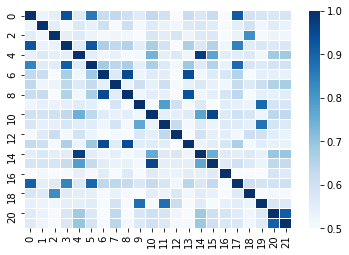

In [15]:
dict_compare_combo = {}

for i in np.arange(len(test_stability)):
    dict_compare_combo[i] = []
    for j in np.arange(len(test_stability)):
        if (i == j):
            dict_compare_combo[i].append(1)
        else:
            dict_compare_combo[i].append(compare_cluster_combo(i,j,test_stability))
            
#show tabel of mean similarity score over all features 
df_sim = pd.DataFrame.from_dict(dict_compare_combo)
ax = sns.heatmap(df_sim, vmin=0.5, vmax=1 , linewidths=0.1 , cmap='Blues'  )

If there occurs more than one cluster-combination, set the clusters used for further analysis to the most common cluster (see combination-count above).

In [11]:
#If there occurs more than one cluster-combination, set the clusters used for further analysis to the most common cluster
perturbation = 8 #the most occuring cluster-combination

#sort the clusters, in this way we always obtain the same cluster numbers 
sort_clusters = test_stability[perturbation].copy()
sort_clusters.sort(key=len)
sort_centers = []
for i in np.arange(k**(l-1)):
    for j in np.arange(k**(l-1)):
        if (sort_clusters[i] == test_stability[perturbation][j]):
            sort_centers.append(test_medoids[perturbation][j])

## Compactness of cluster 

To compute the compactness of a cluster we arangethe samples within the cluster from closest to the medoid to farthest from the medoid. Next we look at the 10, 20, 30, etc. percent of the cluster closest to the medoid, and for each subset we compute the Gower distance between the farest point and the medoid. 

In [17]:
def density_cluster(centers,clusters,c_i):
    indices = clusters[c_i]
    subset = X.loc[indices,:]
    medoid = centers[c_i]
    number = 1000
    for i in np.arange(len(indices)):
        if (indices[i] == medoid):
            number = i 
    subset_distance = gower_distance(subset)[number]
    subset_distance.sort()
    percentage = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
    mean = []
    Max = []
    for p in percentage:
        n_p = round(len(indices)*p)
        if (n_p==0):
            mean.append(0)
            Max.append(0)
        else:
            mean.append(subset_distance[:n_p].mean())
            Max.append(subset_distance[:n_p].max())
    df = pd.DataFrame(list(zip(percentage,mean,Max)),columns=['percentage','mean','max'])
    return Max

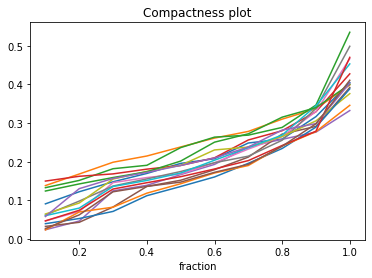

In [18]:
D = {'fraction':[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]}

for i in np.arange(k**(l-1)):
    D[i] = density_cluster(sort_centers,sort_clusters,i)
    
df_density = pd.DataFrame.from_dict(D)
df_density.plot(x='fraction',title='Compactness plot',legend=None)

## Similarity between clusters 

We compute the similarity between two different clusters by comparing the distribution of the features. For all features we compare the fractions of different feature-values, where for numerical features we first disretize the data. 
A similarity score of 0 means that the feature is completely different distributed in both clusters and a similarity score of 1 means that a feature has the same distribution in two clusters. 

In [19]:
#similarity for categroical features

def similarity_cat(clusters,c_i,c_j,feature):
    indices_i = clusters[c_i]
    indices_j = clusters[c_j]
    subset_i = X.loc[indices_i,:]
    subset_j = X.loc[indices_j,:]
    
    value_list = [] #create list with feature values 
    for val in subset_i[feature].unique():
        value_list.append(val)
    for val in subset_j[feature].unique():
        if (val not in value_list):
            value_list.append(val)
    
    sim_score = 0
    for val in value_list:
        if (val in subset_i[feature].unique()):
            frac_i = subset_i[feature].value_counts()[val] / len(subset_i[feature])
        else:
            frac_i = 0
        if (val in subset_j[feature].unique()):
            frac_j = subset_j[feature].value_counts()[val] / len(subset_j[feature])
        else:
            frac_j = 0
        sim_score += min(frac_i,frac_j)
    #print(feature, '\t', "%.2f" % sim_score)
    return sim_score

In [20]:
#similarity for numerical features

def similarity_num(clusters,c_i,c_j,feature):
    indices_i = clusters[c_i]
    indices_j = clusters[c_j]
    subset_i = X.loc[indices_i,:]
    subset_j = X.loc[indices_j,:]
    
    n_i = 10 #number of intervals
    Min = min(subset_i[feature].min(),subset_j[feature].min())
    Max = max(subset_i[feature].max(),subset_j[feature].max())
    rng = np.arange(Min,Max+(Max-Min)/n_i,(Max-Min)/n_i)
    
    sim_score = 0
    for i in np.arange(n_i):
        f_i = len(subset_i[(subset_i[feature]<rng[i+1]) & (subset_i[feature]>rng[i])]) / (len(subset_i))
        f_j = len(subset_j[(subset_j[feature]<rng[i+1]) & (subset_j[feature]>rng[i])]) / (len(subset_j))
        sim_score += min(f_i,f_j)
    #print(feature, '\t', "%.2f" % sim_score)
    output = sim_score
    return output

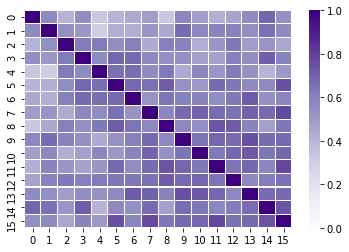

In [21]:
dict_sim = {}
list_scores = []

for c_i in np.arange(len(sort_clusters)):
    dict_sim[c_i] = []
    for c_j in np.arange(len(sort_clusters)):
        list_scores = []
        if (c_i == c_j):
            dict_sim[c_i].append(1)
        else:
            for cat_feature in cat_features:
                list_scores.append(similarity_cat(sort_clusters,c_i,c_j,cat_feature))
            for num_feature in num_features:
                list_scores.append(similarity_num(sort_clusters,c_i,c_j,num_feature))
            mean_score = statistics.mean(list_scores)
            dict_sim[c_i].append(mean_score)
            
#show tabel of mean similarity score over all features 
df_sim = pd.DataFrame.from_dict(dict_sim)
ax = sns.heatmap(df_sim, vmin=0, vmax=1 , linewidths=0.1 , cmap='Purples'  )

For any two clusters we can get more detailed information about their similarity by looking at the feature-wise similarity scores. 

In [22]:
#show for 2 given clusters the similarity score by feature
cluster_i = 3
cluster_j = 6

print('---similarity scores for cluster ',cluster_i,' and ',cluster_j,'---')
for cat_feature in cat_features:
    print(cat_feature, '\t', "%.2f" % similarity_cat(sort_clusters,cluster_i,cluster_j,cat_feature))
for num_feature in num_features:
    print(num_feature, '\t', "%.2f" % similarity_num(sort_clusters,cluster_i,cluster_j,num_feature))

---similarity scores for cluster  3  and  6 ---
Sex 	 1.00
Job 	 0.89
Housing 	 0.92
Saving accounts 	 0.30
Checking account 	 0.18
Purpose 	 0.88
Age 	 0.64
Credit amount 	 0.58
Duration 	 0.73


## Variability

In [12]:
#compute variability of numerical features
def numerical_std(numerical_variable):
    name = numerical_variable.name
    Vmin = numerical_variable.min()
    Vmax = numerical_variable.max()
    Vnorm = (numerical_variable-Vmin)/(Vmax-Vmin)
    norm_std = statistics.stdev(Vnorm.tolist())
    return norm_std

In [13]:
#compute variability of categorical features
def categorical_variation(categorical_variable):
    name = categorical_variable.name
    q = categorical_variable.nunique()
    n = categorical_variable.count() 
    values_list = categorical_variable.drop_duplicates().to_list()
    if (q==1):
        return 0 
    else:
        frequencies = []
        for val in values_list:
            f = categorical_variable.value_counts()[val] / n
            frequencies.append(f)
        f2 = 0
        for i in np.arange(q):
            f2 += (frequencies[i]**2)
        v = 1 - np.sqrt(f2)
        v_s = v / (1-1/(np.sqrt(q)))
        return v_s

In [14]:
#prints variability of a cluster 
def variability(matrix,clusters,cluster_number):
    c_indices = clusters[cluster_number]
    matrix_subset = matrix.loc[c_indices,:]
    for column in matrix.columns:
        if (column in cat_features):
            print(column , '\t', "%.2f" % categorical_variation(matrix_subset[column]))
        elif (column in num_features):
            print(column , '\t', "%.2f" % min(numerical_std(matrix_subset[column])/np.sqrt(1/12),1) )

In [15]:
#returns list of variability of a cluster
def variability2(matrix,clusters,cluster_number):
    c_indices = clusters[cluster_number]
    matrix_subset = matrix.loc[c_indices,:]
    list_var = []
    for column in matrix.columns:
        if (column in cat_features):
            list_var.append(categorical_variation(matrix_subset[column]))
        elif (column in num_features):
            list_var.append(min(numerical_std(matrix_subset[column])/np.sqrt(1/12),1))
    return list_var

Variability plot shows for each cluster the feature-wise variability, where 0 indicates a low variability and 1 a high variability. 

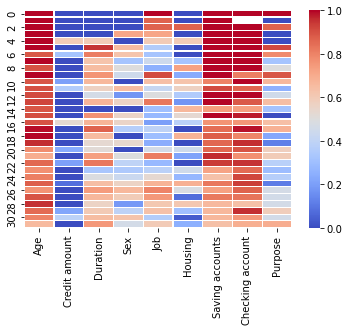

In [17]:
dict_var = {}
for i in np.arange(len(sort_clusters)):
    dict_var[i] = variability2(X,sort_clusters,i)

df_var = pd.DataFrame.from_dict(dict_var, orient='index', columns=all_features)
ax = sns.heatmap(df_var, vmin=0, vmax=1 , linewidths=0.1 , cmap='coolwarm'  )

We can also print the variability. 

In [28]:
for i in np.arange(len(sort_clusters)):
    print('---Variability of cluster ',i,'---')
    variability(X,sort_clusters,i)

---Variability of cluster  0 ---
Age 	 0.99
Sex 	 0.25
Job 	 0.60
Housing 	 0.37
Saving accounts 	 0.43
Checking account 	 0.70
Credit amount 	 1.00
Duration 	 1.00
Purpose 	 0.34
---Variability of cluster  1 ---
Age 	 0.77
Sex 	 0.00
Job 	 0.77
Housing 	 0.59
Saving accounts 	 0.89
Checking account 	 0.31
Credit amount 	 0.98
Duration 	 0.95
Purpose 	 0.69
---Variability of cluster  2 ---
Age 	 0.83
Sex 	 0.22
Job 	 0.83
Housing 	 0.66
Saving accounts 	 0.69
Checking account 	 0.23
Credit amount 	 0.86
Duration 	 0.88
Purpose 	 0.69
---Variability of cluster  3 ---
Age 	 0.96
Sex 	 0.00
Job 	 0.72
Housing 	 0.65
Saving accounts 	 0.76
Checking account 	 0.14
Credit amount 	 0.78
Duration 	 0.83
Purpose 	 0.45
---Variability of cluster  4 ---
Age 	 0.79
Sex 	 0.00
Job 	 0.53
Housing 	 0.29
Saving accounts 	 0.41
Checking account 	 0.58
Credit amount 	 0.72
Duration 	 0.67
Purpose 	 0.45
---Variability of cluster  5 ---
Age 	 0.94
Sex 	 0.00
Job 	 0.54
Housing 	 0.43
Saving accounts 	 0